# Visual Search with MXNet Gluon and 1M Amazon Product images

In this tutorial we will create a Visual Search engine for browsing 1M amazon product images.

First step, indexing the image dataset by computing the image embeddings using a pre-trained network as a featurizer:

![](images/intro_1.png)

Second step, query the index using an efficient K-NN search algorithm, here we use [Hierarchical Navigable Small World graphs (HNSW)](https://github.com/nmslib/hnsw)

![](images/intro_2.png)

**Pre-requisite**:
- MXNet: `pip install --pre mxnet-cu91`
- hnswlib (follow the guide here: https://github.com/nmslib/hnsw)

In [34]:
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import multiprocessing
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import numpy as np
import wget
import imghdr
import json
import pickle
import hnswlib
import numpy as np
import glob, os, time
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import urllib.parse
import urllib
import gzip
import os
import tempfile
import glob
from os.path import join
%matplotlib inline

Data originally from here:
http://jmcauley.ucsd.edu/data/amazon/

*Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015*

## Downloading images
We only use a subset of the total number of images, here 1M
(it takes about 40 minutes to download all the data on an ec2 instance)

In [4]:
subset_num = 1000000

Beware, if using the full dataset this will download **300GB** of images, make sure you have the appropriate hardware and connexion!
Alternatively, just set `images_path` to a directory containing images following this format `ID.jpg`

In [5]:
data_path = 'metadata.json'
images_path = join('data','amazon_images_subset')

Download the metadata.json file that contains the URL of the images

In [6]:
if not os.path.isfile(data_path):
    # Downloading the metadata, 3.1GB, unzipped 9GB
    !wget -nv https://s3.us-east-2.amazonaws.com/mxnet-public/stanford_amazon/metadata.json.gz
    !gzip -d metadata.json.gz

if not os.path.isdir(images_path):
    os.makedirs(images_path)

In [5]:
num_lines = 0
num_lines = sum(1 for line in open(data_path))
assert num_lines >= subset_num, "Subset needs to be smaller or equal to total number of example"

In [6]:
def parse(path, num_cpu, modulo):
    g = open(path, 'r')
    for i, l in enumerate(g):
        if (i >= num_lines - subset_num and i%num_cpu == modulo):
            yield eval(l)

In [7]:
def download_files(modulo):
    for i, data in enumerate(parse(data_path, NUM_CPU, modulo)):
        if (i%1000000==0):
            print(i)
        if 'imUrl' in data and data['imUrl'] is not None and 'categories' in data and data['imUrl'].split('.')[-1] == 'jpg':
            url = data['imUrl']
            try:
                path = os.path.join(images_path, data['asin']+'.jpg')
                if not os.path.isfile(path):
                    file = urllib.request.urlretrieve(url, path)
            except:
                print("Error downloading {}".format(url))

Downloading the images using 10 times more processes than cores

In [8]:
NUM_CPU = multiprocessing.cpu_count()*10

In [ ]:
pool = multiprocessing.Pool(processes=NUM_CPU)
results = pool.map(download_files, list(range(NUM_CPU)))

In [ ]:
# Removing all the fake jpegs
list_files = glob.glob(os.path.join(images_path, '**.jpg'))
for file in list_files:
    if imghdr.what(file) != 'jpeg':
        print('Removed {} it is a {}'.format(file, imghdr.what(file)))
        os.remove(file)

## Generate the image embeddings

In [7]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 512
SIZE = (224, 224)
MEAN_IMAGE= mx.nd.array([0.485, 0.456, 0.406])
STD_IMAGE = mx.nd.array([0.229, 0.224, 0.225])

### Featurizer
We use a pre-trained model from the model zoo

In [12]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) else mx.cpu()

Networks from the model-zoo follow the convention that the features are on the `.features` property and output on the `.output` property. It makes it very easy to transform any pre-trained network in featurizer.

In [13]:
net = vision.resnet18_v2(pretrained=True, ctx=ctx).features

In [15]:
net

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats

### Save the pre-trained featurizer

In [16]:
net.hybridize()

In [20]:
net(mx.nd.ones((1,3,224,224), ctx=ctx))
net.export(join('mms','visualsearch'))

### Data Transform
to convert the images to a shape usable by the network

In [21]:
def transform(image, label):
    resized = mx.image.resize_short(image, SIZE[0]).astype('float32')
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    cropped /= 255.
    normalized = mx.image.color_normalize(cropped,
                                      mean=MEAN_IMAGE,
                                      std=STD_IMAGE) 
    transposed = nd.transpose(normalized, (2,0,1))
    return transposed, label

### Data Loading

In [23]:
empty_folder = tempfile.mkdtemp()
# Create an empty image Folder Data Set
dataset = ImageFolderDataset(root=empty_folder, transform=transform)

In [24]:
list_files = glob.glob(os.path.join(images_path, '**.jpg'))

In [26]:
print("[{}] images".format(len(list_files)))

[959440] images


#### Creating data files for offline inference

In [27]:
idx_ASIN = []
for file in list_files:
    idx_ASIN.append(file.split('/')[-1].split('.')[0])

In [28]:
ASINs = set(idx_ASIN)    

In [30]:
def get_ASIN_data(modulo):
    ASIN_data = {}
    file = open(data_path, 'r')
    for i, line in enumerate(file):
        if i % NUM_CPU == modulo:
            data = eval(line)
            if i % 1000000 == 0:
                print("[{}] product data processed".format(i))
            if data['asin'] in ASINs:
                ASIN_data[data['asin']] = {
                    'price':data['price'] if 'price' in data else 'NA',
                    'url':data['imUrl'],
                    'title': data['title'] if 'title' in data else 'NA',
                    'ASIN':data['asin']
                }
    return ASIN_data

In [31]:
NUM_CPU = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=NUM_CPU)
results = pool.map(get_ASIN_data, list(range(NUM_CPU)))

[0] product data processed
[1000000] product data processed
[2000000] product data processed
[3000000] product data processed
[4000000] product data processed
[5000000] product data processed
[6000000] product data processed
[7000000] product data processed
[8000000] product data processed
[9000000] product data processed


In [32]:
ASIN_data = { k: v for d in results for k, v in d.items() }

In [35]:
idx_asin_file = join('mms','idx_ASIN.pkl')
ASIN_data_file = join('mms', 'ASIN_data.pkl')
pickle.dump(idx_ASIN, open(idx_asin_file, 'wb'), protocol=2)
pickle.dump(ASIN_data, open(ASIN_data_file, 'wb'), protocol=2)

Because of the data validation and invalid URL, our actual subset is smaller than the one requested

In [17]:
idx_ASIN = pickle.load(open(idx_asin_file, 'rb'))
ASIN_data = pickle.load(open(ASIN_data_file, 'rb'))

In [36]:
# We map the files to the dataset

In [37]:
dataset.items = list(zip(list_files, [0]*len(list_files)))

We load the dataset in a dataloader with as many workers as CPU cores

In [38]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, last_batch='keep', shuffle=False, num_workers=multiprocessing.cpu_count())

### Featurization

In [39]:
features = np.zeros((len(dataset), EMBEDDING_SIZE), dtype=np.float32)

In [40]:
%%time
tick = time.time()
n_print = 100
j = 0
for i, (data, label) in enumerate(dataloader):
    data = data.as_in_context(ctx)
    if i%n_print == 0 and i > 0:
        print("{0} batches, {1} images, {2:.3f} img/sec".format(i, i*BATCH_SIZE, BATCH_SIZE*n_print/(time.time()-tick)))
        tick = time.time()
    output = net(data)
    features[(i)*BATCH_SIZE:(i+1)*max(BATCH_SIZE, len(output)), :] = output.asnumpy().squeeze()

100 batches, 25600 images, 1368.683 img/sec
200 batches, 51200 images, 2174.771 img/sec
300 batches, 76800 images, 2147.662 img/sec
400 batches, 102400 images, 2181.540 img/sec
500 batches, 128000 images, 2173.273 img/sec
600 batches, 153600 images, 2165.015 img/sec
700 batches, 179200 images, 2155.162 img/sec
800 batches, 204800 images, 2175.698 img/sec
900 batches, 230400 images, 2140.403 img/sec
1000 batches, 256000 images, 2140.320 img/sec
1100 batches, 281600 images, 2167.158 img/sec
1200 batches, 307200 images, 2158.666 img/sec
1300 batches, 332800 images, 2145.287 img/sec
1400 batches, 358400 images, 2123.446 img/sec
1500 batches, 384000 images, 2123.271 img/sec
1600 batches, 409600 images, 2138.888 img/sec
1700 batches, 435200 images, 2163.998 img/sec
1800 batches, 460800 images, 2136.956 img/sec
1900 batches, 486400 images, 2166.607 img/sec
2000 batches, 512000 images, 2147.204 img/sec
2100 batches, 537600 images, 2138.360 img/sec
2200 batches, 563200 images, 2170.411 img/sec


## Create the search index

In [41]:
# Number of elements in the index
num_elements = len(features)
labels_index = np.arange(num_elements)

In [57]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = EMBEDDING_SIZE) # possible options are l2, cosine or ip

In [58]:
%%time 
# Initing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 100, M = 16)

# Element insertion (can be called several times):
int_labels = p.add_items(features, labels_index)

CPU times: user 4min 48s, sys: 16.1 s, total: 5min 4s
Wall time: 1min 47s


In [48]:
# Controlling the recall by setting ef:
p.set_ef(100) # ef should always be > k

In [49]:
p.save_index(join('mms', 'index.idx'))

In [50]:
p.load_index(join('mms','index.idx'))

### Testing

We test the results by sampling random images from the dataset and searching their K-NN

In [51]:
def plot_predictions(images):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(15, 15))
    gs.update(hspace=0.1, wspace=0.1)
    for i, (gg, image) in enumerate(zip(gs, images)):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image, cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("result [{}]".format(i))
        if i == 0:
            plt.setp(ax.spines.values(), color='red')
            ax.axes.set_title("SEARCH".format(i))

In [52]:
def search(N, k):
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    q_labels, q_distances = p.knn_query([features[N]], k = k)
    images = [plt.imread(dataset.items[label][0]) for label in q_labels[0]]
    plot_predictions(images)

### Random testing

CPU times: user 228 ms, sys: 4 ms, total: 232 ms
Wall time: 229 ms


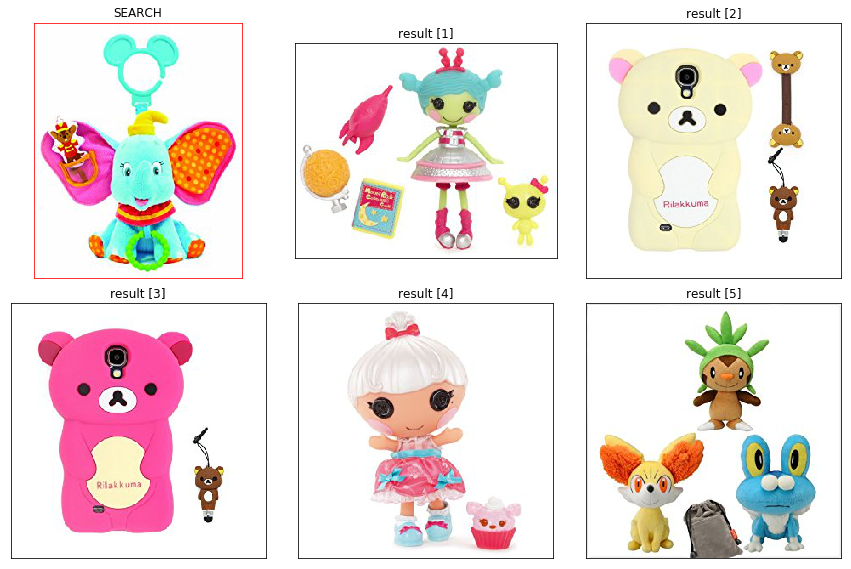

In [53]:
%%time
index = np.random.randint(0,len(features))
k = 6
search(index, k)

### Manual testing

In [54]:
path = 'dress.jpg'

In [55]:
p.set_ef(300) # ef should always be > k
image = plt.imread(path)[:,:,:3]
image_t, _ = transform(nd.array(image), 1)
output = net(image_t.expand_dims(axis=0).as_in_context(ctx))
labels, distances = p.knn_query([output.asnumpy().reshape(-1,)], k = 5)
images = [image]
images += [plt.imread(dataset.items[label][0]) for label in labels[0]]

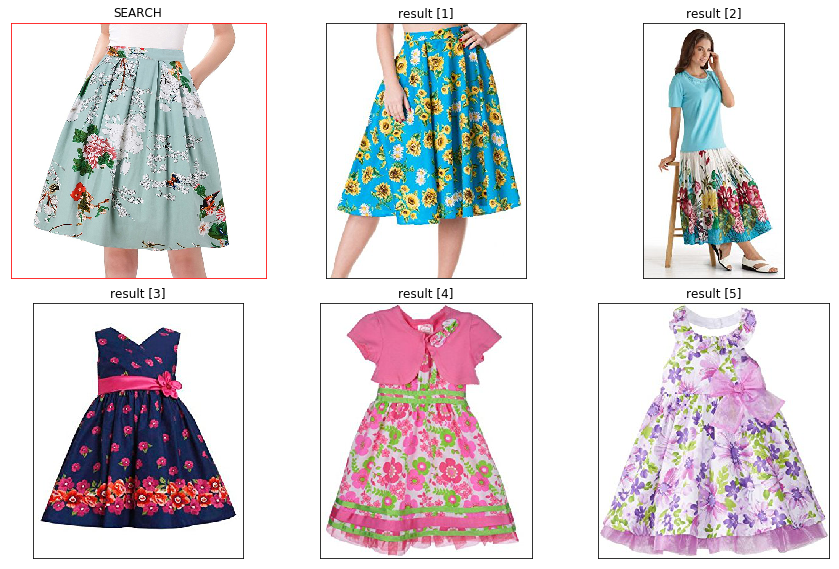

In [56]:
plot_predictions(images)